# Project \#46: European Transportation Network II

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import networkx as nx
from helper_functions import *

### Part 1: creation of the preliminary network

Index(['FCsubtype', 'inspireId', 'beginLifes', 'F_CODE', 'ICC', 'EXS', 'FCO',
       'GAW', 'LLE', 'NAMN1', 'NAMN2', 'NAMA1', 'NAMA2', 'NLN1', 'NLN2', 'RCO',
       'RGC', 'RRA', 'RRC', 'RSD', 'RSU', 'TEN', 'TUC', 'SHAPE_Leng',
       'geometry'],
      dtype='object')
<class 'shapely.geometry.linestring.LineString'> LINESTRING (0.5972559999997884 43.64944749999984, 0.5974139999997874 43.650735499999854)
Analyzing country =  IT
Analyzing country =  LT
Analyzing country =  LU
Analyzing country =  LV
Analyzing country =  MD
Analyzing country =  MK
Analyzing country =  ND
Analyzing country =  NL
Analyzing country =  NO
Analyzing country =  PL
Analyzing country =  PT
Analyzing country =  RO
Analyzing country =  RS
Analyzing country =  SE
Analyzing country =  SI
Analyzing country =  SK
Analyzing country =  UA


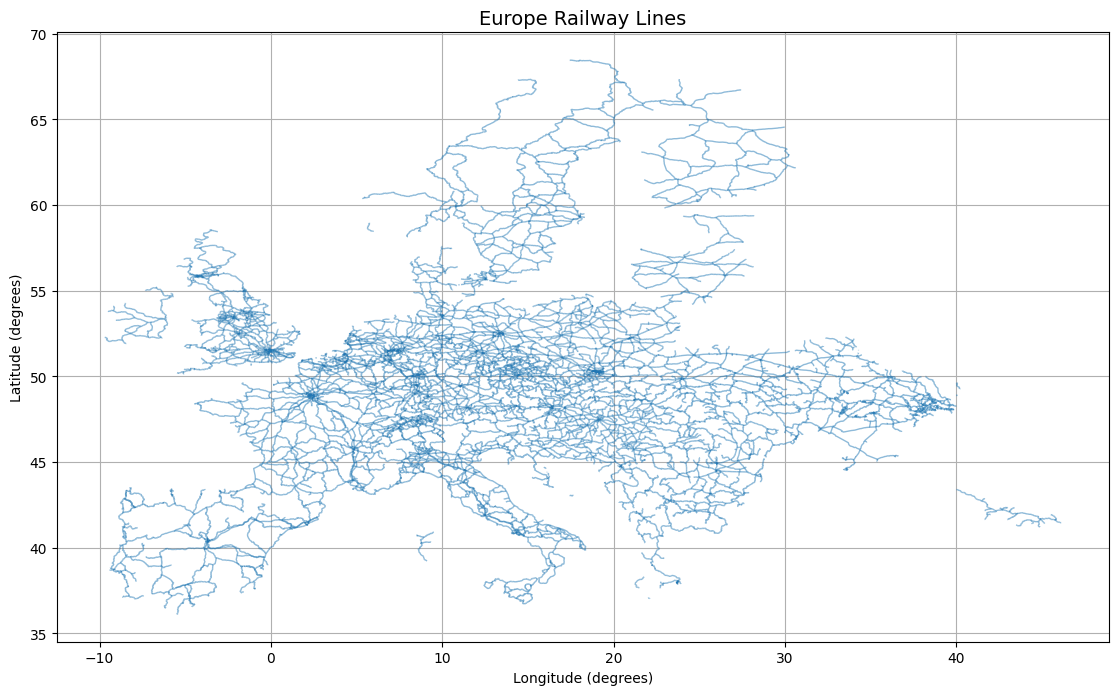

In [7]:
keys_list = sorted(list(ICC_labels.keys()))
start_index = keys_list.index('IT')
keys_sublist = keys_list[start_index:]

rails = gpd.read_file("input_data/RailrdL.shp")
print(rails.columns)
columns_to_extract = ['ICC', 'EXS', 'NAMA1', 'RSD', 'TUC', 'geometry']
rails = gpd.GeoDataFrame(rails[columns_to_extract], geometry=rails.geometry)
rails['country_name'] = rails['ICC'].map(ICC_labels)
rails = rails[rails['EXS'] == 28]

fig, ax = plt.subplots(1, 1, figsize=(11.69, 8.27))
rails.plot(ax=ax,  linewidth = 1, alpha = 0.5)
ax.set_xlabel("Longitude (degrees)")
ax.set_ylabel("Latitude (degrees)")
plt.title("Europe Railway Lines", fontsize = 14, loc = 'center') #fontweight = 'bold'
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
ax.grid()
#plt.savefig("new_outputs/europe_rails.pdf", dpi = 500 )

print(type(rails.geometry[0]), rails.geometry[0])

for country_code in keys_sublist:
    print("Analyzing country = ", country_code)
    rails_temp = rails[rails['ICC'] == country_code].copy()
    G = nx.Graph()

    node_coords = {} # dictionary to store coordinates of each node: {(1.0, 2.0): 0, (23.4, 45): 1 ,...}
    node_counter = 1 #node index starts form one but is incremented inside add_node function
    # Fill graph object G
    for line in rails_temp.geometry:
        coords = list(line.coords)
        for i in range(len(coords) - 1):
            start_node, node_counter = add_node(G, coords[i], node_coords, node_counter)
            end_node, node_counter = add_node(G, coords[i + 1], node_coords, node_counter)
            G.add_edge(start_node, end_node)

    # Output node list and edge list to .csv files
    node_path = f"csv_outputs/preliminary_networks/{country_code}_raw_nodes.csv"
    edges_path = f"csv_outputs/preliminary_networks/{country_code}_raw_edges.csv"
    nodes_with_attributes = list(G.nodes(data=True))
    node_data = []
    for node_id, attributes in nodes_with_attributes:
        node_data.append([node_id, attributes.get('longitude'), attributes.get('latitude')])
    nodes_df = pd.DataFrame(node_data, columns=['node_ID', 'longitude', 'latitude'])
    nodes_df.to_csv(node_path, index=False)
    edges = list(G.edges(data=False))
    edges_data = [(source, target) for source, target in edges]
    edges_df = pd.DataFrame(edges_data, columns=['nodeID_from', 'nodeID_to'])
    edges_df.to_csv(edges_path, index=False)


## Part 2: city graph creation

### 2.1 read stations data from "RailrdC.shp" and store in files "{ICC}_city_nodes.csv"

In [8]:
stations = gpd.read_file("input_data/RailrdC.shp") ## careful! directory must also  contain "RailrdC.dbf" and "RailrdC.shx"
columns_to_extract = ['ICC', 'TFC', 'NAMA1', 'RStationID', 'TUC']
stations = gpd.GeoDataFrame(stations[columns_to_extract], geometry=stations.geometry)
stations['Country Name'] = stations['ICC'].map(ICC_labels)
stations = stations.sort_values(by=['ICC', 'NAMA1'])
stations = stations.reset_index(drop=True)
stations['lat'] = stations.geometry.y
stations['lon'] = stations.geometry.x
print(type(stations.geometry[0]), stations.geometry[0])

stations = stations.drop(columns= ['geometry', 'RStationID', 'TFC', 'TUC'])
stations = stations.rename(columns={'ICC': 'country_IS03', 'NAMA1' : 'node_label', 'lat': 'latitude', 'lon': 'longitude', 'Country Name': 'country_name'})
stations = stations[['node_label', 'latitude', 'longitude', 'country_name', 'country_IS03']]

# .csv file for the whole Europe
index_list = np.arange(1, len(stations)+1)
stations.insert(0, 'node_ID', index_list)
stations.to_csv("csv_outputs/preliminary_networks/EU_city_nodes.csv", index = False )

# .csv files for each european country IT - UA
keys_list = sorted(list(ICC_labels.keys()))
start_index = keys_list.index('IT')
keys_sublist = keys_list[start_index:]
stations = stations.drop( columns= ['node_ID'])

for country_code in keys_sublist:
    stations_temp = stations[stations["country_IS03"] == country_code].copy()
    stations_names, counts = np.unique(stations_temp['node_label'], return_counts=True)
    if(any(i > 1 for i in counts)):
        for station_name, count in zip(stations_names, counts):
            if(count >1):
                indices = stations_temp.index[stations_temp['node_label'] == station_name][1:]
                stations_temp = stations_temp.drop(indices)
                stations_temp = stations_temp.reset_index(drop=True)
    new_index_list = np.arange(1, len(stations_temp) + 1)
    stations_temp.insert(0, 'node_ID', new_index_list)
    stations_temp.to_csv(f'csv_outputs/preliminary_networks/{country_code}_metadata.csv', index=False)


<class 'shapely.geometry.point.Point'> POINT (14.470226499999796 47.57296499999984)


### 2.2 label nodes of the preliminary network and store new node list in "{country_code}_raw_nodes_labeled.csv"

In [10]:
for country_code in keys_sublist:
    print("Analyzing country = ", country_code)
    test_nodes = pd.read_csv(f"csv_outputs/preliminary_networks/{country_code}_raw_nodes.csv")
    city_nodes = pd.read_csv(f'csv_outputs/preliminary_networks/{country_code}_metadata.csv')

    test_nodes['label'] = 'empty' # values= empty or city name
    test_nodes['is_near_city'] = 'empty'
    
    # label the test nodes which correspond to cities (column label)
    for i in np.arange(0, len(test_nodes)):
        lon = test_nodes.at[i, 'longitude']
        lat = test_nodes.at[i, 'latitude']
        for j in np.arange(0, len(city_nodes)):
            longitude = city_nodes['longitude'].iloc[j]
            latitude = city_nodes['latitude'].iloc[j]
            if(flexible_matching(lat, latitude, threshold= 0.03) and flexible_matching(lon, longitude, threshold = 0.03)):
                test_nodes.at[i, 'label'] = city_nodes['node_label'].iloc[j]

    # check if duplicates are present and fill "is_near_city" column
    names, counts = np.unique(test_nodes['label'], return_counts=True)
    if any(i > 1 and name != 'empty' for name, i in zip(names, counts)):
        for name, count in zip(names, counts):
            if(count >1 and name != 'empty'):
                ### the closest node becomes the official city node ###
                ### the other nodes become the "near city" nodes ###
                ind = city_nodes.index[city_nodes['node_label'] == name].tolist()[0]
                real_latitude = city_nodes['latitude'].iloc[ind]
                real_longitude = city_nodes['longitude'].iloc[ind]
                distances = []
                indices = test_nodes.index[test_nodes['label'] == name]
                for i in indices:
                    lat = test_nodes['latitude'].iloc[i]
                    lon = test_nodes['longitude'].iloc[i]
                    dist = (lat-real_latitude)**2 + (lon-real_longitude)**2
                    distances.append(dist)
                min_dist_index = distances.index(min(distances))
                chosen_index = indices[min_dist_index]
                for i in indices:
                    if i != chosen_index:
                        test_nodes.loc[i, 'label'] = 'empty'
                        test_nodes.loc[i, 'is_near_city'] = name

    names, counts = np.unique(test_nodes['label'], return_counts=True)
    test_nodes.to_csv(f"csv_outputs/preliminary_networks/{country_code}_raw_nodes_labeled.csv")

Analyzing country =  IT
Analyzing country =  LT
Analyzing country =  LU
Analyzing country =  LV
Analyzing country =  MD
Analyzing country =  MK
Analyzing country =  ND
Analyzing country =  NL
Analyzing country =  NO
Analyzing country =  PL
Analyzing country =  PT
Analyzing country =  RO
Analyzing country =  RS


KeyboardInterrupt: 

### 2.3 Create edges and store final node and edge list in output files "{country_code}_nodes.csv" and "{country_code}_edges.csv" 

A distance cutoff parameter is introduced: we look for an edge between city_a and city_b only if distance(city-a, city_b) < radius
While for some of the countries the cutoff (only) speeds up computation by a few minutes, for other (like poland PL) it is indispensable to get results in a reasonable time (without cutoff, Poland edge search runs for over 40 minutes!)
An adequate value for the cutoff must be chosen manually for each country. Below I report the list of cutoffs I used:

- IT, 3, 1m45s, 
- LT, infty
- LU, infty
- LV, infty
- MD, infty, 0m0s
- MK, infty, 0m3s
- ND, infty  0m0s
- NL, infty, 0m32s
- NO, 5, 0m7s
- PL, 0.6, 8m30s 
- PT, infty,  0m12s
- RO, 2, 10m20s
- RS, infty, 0m15s
- SE, infty, 2m11s
- SI, infty, 0m0s, V(graph)$size <- deg * 1.5  + 1, deg > max(deg) - 2
- SK, infty, 7m0s
- UA, 2.5, 9m40s

In [9]:
country_code = 'RO'
radius = 2
test_edges = pd.read_csv(f"csv_outputs/preliminary_networks/{country_code}_raw_edges.csv")
test_nodes = pd.read_csv(f"csv_outputs/preliminary_networks/{country_code}_raw_nodes_labeled.csv")

G = nx.Graph()
for index, row in test_edges.iterrows():
    G.add_edge(row['nodeID_from'], row['nodeID_to'])
label_dict = pd.Series(test_nodes.label.values, index=test_nodes.node_ID).to_dict()
is_near_city_dict = pd.Series(test_nodes.is_near_city.values, index=test_nodes.node_ID).to_dict()
latitude_dict = pd.Series(test_nodes.latitude.values, index=test_nodes.node_ID).to_dict()
longitude_dict = pd.Series(test_nodes.longitude.values, index=test_nodes.node_ID).to_dict()

nx.set_node_attributes(G, label_dict, 'label')
nx.set_node_attributes(G, is_near_city_dict, 'is_near_city')
nx.set_node_attributes(G, longitude_dict, 'longitude')
nx.set_node_attributes(G, latitude_dict, 'latitude')

G_new = nx.Graph()
unique_labels = test_nodes['label'].unique()
names = [label for label in unique_labels if label != 'empty']

for i in np.arange(0, len(names)):
    name_from = names[i]
    for j in np.arange(i+1, len(names)):
        name_to = names[j]
        node_from = find_node_by_label(G, name_from)
        node_to = find_node_by_label(G, name_to)
        if node_from and node_to:
            ## only test if distance less than radius
            lat_from = G.nodes[node_from]["latitude"]
            lat_to = G.nodes[node_to]["latitude"]
            lon_from = G.nodes[node_from]["longitude"]
            lon_to = G.nodes[node_to]["longitude"]
            sqrdist = (lon_from - lon_to)**2 + (lat_from - lat_to)**2
            dist = np.sqrt(sqrdist)
            #print(f"distance between {name_from} and {name_to} is: {dist}")
            if(dist < radius):
                if (check_edge(G, node_from, node_to)):
                    G_new.add_node(node_from)
                    G_new.add_node(node_to)
                    G_new.nodes[node_from].update(G.nodes[node_from])
                    G_new.nodes[node_to].update(G.nodes[node_to])
                    G_new.add_edge(node_from, node_to)
# Rename nodes to sequential integers
original_nodes = list(G_new.nodes())
rename_mapping = {original_nodes[i]: i+1 for i in range(len(original_nodes))}
G_new = nx.relabel_nodes(G_new, rename_mapping)
# Create output files
nodes_with_attributes = list(G_new.nodes(data=True))
node_data = []
for node_id, attributes in nodes_with_attributes:
    node_data.append([node_id, attributes.get('label'), attributes.get('longitude'), attributes.get('latitude')])
nodes_df = pd.DataFrame(node_data, columns=['node_ID', 'node_label', 'longitude', 'latitude'])
nodes_df.to_csv(f"csv_outputs/final_networks/{country_code}_nodes.csv", index=False)
edges_with_attributes = list(G_new.edges(data=False))
edges_data = [(source, target) for source, target in edges_with_attributes]
edges_df = pd.DataFrame(edges_data, columns=['nodeID_from', 'nodeID_to'])
edges_df.to_csv(f"csv_outputs/final_networks/{country_code}_edges.csv", index=False)